In [1]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [2]:
import sys
import os
folder = '/content/gdrive/My Drive/Colab Notebooks/my_project1/deep-learning/utils'
os.chdir(folder)

In [3]:
import torch.nn as nn
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.custom_resnet import ResnetCustomCifa10
from models.resnet_gradcam import ResNet18_GradCam
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from albumentations import *
from albumentations.pytorch import ToTensor
from gradcam import *
from albumentation import AlbumentationImageDataset
import matplotlib.pyplot as plt
from lr_finder import LRFinder
from  imgaug import augmenters

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
model_obj = ResnetCustomCifa10()

# create object for Model
device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model_obj)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

### Apply Albumentation

In [5]:
patch_size = 32
custom_transforms = [
       HorizontalFlip(),
       RandomCrop(32, 32, p=4),
       Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
       Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
       ToTensor()
    ]

train_transforms = Compose(custom_transforms)
test_transform = Compose(
    [
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     ToTensor(),
     ])
data_set_obj = DataSetInfo("cifa", "./data")
train_transforms = AlbumentationImageDataset(data_set_obj, transforms = train_transforms)
test_transforms = AlbumentationImageDataset(data_set_obj, transforms = test_transform)


### Get Train and Test data set

In [6]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [7]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=512)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Display some training images to visualize the effect of cutout

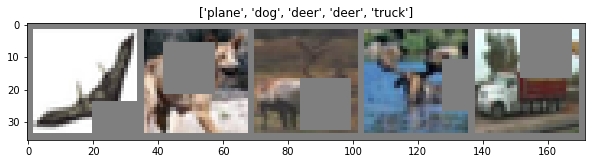

In [ ]:
classes= ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Plot.plot_transormed_random_images(train_loader, classes)

### **Visualize cyclic triangle using max lr, end lr and num of iterations which is used for lr finder**

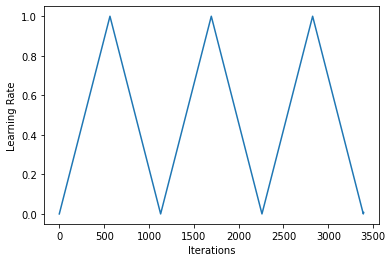

In [42]:
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

# Demo of how the LR varies with iterations
num_iterations = 3395
stepsize = 565
base_lr = 1e-4
max_lr = 1
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(lr_trend)

In [9]:
from statecacher import StateCacher
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.001, lr=1e-3, momentum=0.9) 
criterion = nn.NLLLoss() # As softmax added in model
stored_model = StateCacher(model, optimizer, criterion)

### **Run the range test to find the Max lr**

97.0
3395.0



Learning rate search finished. See the graph with {finder_name}.plot()


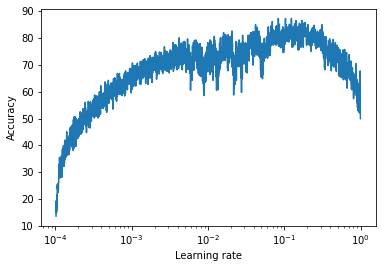

Best acc 87.3
Best LR:  0.08326219372576217


In [ ]:
num_batches = np.floor(len(train_loader.dataset)/512)
total_epochs = 35
num_iter = total_epochs * num_batches
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-4, end_lr=1,num_iter=int(num_iter))
lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

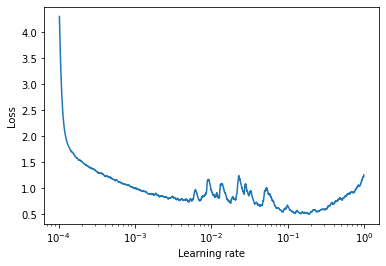

Best loss 0.5033444953807062
Best LR:  0.18947356004061547


In [ ]:
lr_finder.plot(plot_case="loss")
best_lr = lr_finder.get_best_lr(case="loss")

### Reset the model to initial State

In [ ]:
lr_finder.reset()

### Use OneCycleLR for scheduler and train the model

In [10]:
max_lr = 0.08326219372576217  #best lr from lrfinder w.r.t max accuracy
EPOCHS = 24
steps_per_epoch = len(train_loader)
total_steps = EPOCHS * steps_per_epoch
pc_start = 5/EPOCHS
steps_per_epoch = (len(train_set)/train_loader.batch_size)*2

optimizer = helper_obj.get_l2_regularizer(weight_decay=0.001, lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = max_lr, total_steps=None, epochs=EPOCHS,
                                                steps_per_epoch=len(train_loader), pct_start=pc_start, anneal_strategy='linear',
                                                cycle_momentum=False, base_momentum=0.9, max_momentum=0.95, div_factor=10, final_div_factor=1)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []
criterion = nn.NLLLoss()
lr_update = []
for epoch in range(1, EPOCHS+1):
    lr_update.append(optimizer.param_groups[0]['lr'])
    print("EPOCH:", epoch, "LR: ",lr_update[-1])
    train_obj.train(model, device, train_loader, optimizer, criterion, scheduler=scheduler)
    if epoch < EPOCHS:
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=False, trueclassified_required=False, classes=classes, class_accuracy=90)
    else:
        # store only last epochsreult for misclassfied and trueclassified images
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=True, trueclassified_required=True, classes=classes, class_accuracy=90)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])
miscassified_images = test_obj.misclassified_images
correctcassified_images = test_obj.trueclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR:  0.008326219372576217


Train Set: Train Loss=2.0772998332977295 Batch_id=97 Accuracy=18.85: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 2881/10000 (28.81%)

EPOCH: 2 LR:  0.02334406290348056


Train Set: Train Loss=2.031137704849243 Batch_id=97 Accuracy=30.54: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4330/10000 (43.30%)

EPOCH: 3 LR:  0.038361906434384904


Train Set: Train Loss=2.0156538486480713 Batch_id=97 Accuracy=39.70: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 4055/10000 (40.55%)

EPOCH: 4 LR:  0.05337974996528924


Train Set: Train Loss=1.5573314428329468 Batch_id=97 Accuracy=48.25: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 5062/10000 (50.62%)

EPOCH: 5 LR:  0.06839759349619359


Train Set: Train Loss=0.9747030138969421 Batch_id=97 Accuracy=56.99: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6352/10000 (63.52%)

EPOCH: 6 LR:  0.08322194884157678


Train Set: Train Loss=0.8788959980010986 Batch_id=97 Accuracy=65.44: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6976/10000 (69.76%)

EPOCH: 7 LR:  0.07927795019140911


Train Set: Train Loss=0.7832570672035217 Batch_id=97 Accuracy=71.95: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7354/10000 (73.54%)

EPOCH: 8 LR:  0.07533395154124142


Train Set: Train Loss=0.7068531513214111 Batch_id=97 Accuracy=75.58: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7835/10000 (78.35%)

EPOCH: 9 LR:  0.07138995289107374


Train Set: Train Loss=0.6279510259628296 Batch_id=97 Accuracy=78.34: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8139/10000 (81.39%)

EPOCH: 10 LR:  0.06744595424090606


Train Set: Train Loss=0.4820730686187744 Batch_id=97 Accuracy=80.77: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8081/10000 (80.81%)

EPOCH: 11 LR:  0.06350195559073837


Train Set: Train Loss=0.4864688217639923 Batch_id=97 Accuracy=82.15: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8196/10000 (81.96%)

EPOCH: 12 LR:  0.05955795694057069


Train Set: Train Loss=0.40745657682418823 Batch_id=97 Accuracy=83.86: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8452/10000 (84.52%)

EPOCH: 13 LR:  0.05561395829040301


Train Set: Train Loss=0.42291608452796936 Batch_id=97 Accuracy=85.71: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8605/10000 (86.05%)

EPOCH: 14 LR:  0.05166995964023533


Train Set: Train Loss=0.3960052728652954 Batch_id=97 Accuracy=86.97: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8588/10000 (85.88%)

EPOCH: 15 LR:  0.04772596099006765


Train Set: Train Loss=0.3272732198238373 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8555/10000 (85.55%)

EPOCH: 16 LR:  0.04378196233989997


Train Set: Train Loss=0.25621843338012695 Batch_id=97 Accuracy=89.19: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8732/10000 (87.32%)

EPOCH: 17 LR:  0.03983796368973229


Train Set: Train Loss=0.2561885714530945 Batch_id=97 Accuracy=90.38: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8835/10000 (88.35%)

EPOCH: 18 LR:  0.0358939650395646


Train Set: Train Loss=0.23432867228984833 Batch_id=97 Accuracy=91.57: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8746/10000 (87.46%)

EPOCH: 19 LR:  0.03194996638939692


Train Set: Train Loss=0.22034002840518951 Batch_id=97 Accuracy=92.53: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8857/10000 (88.57%)

EPOCH: 20 LR:  0.02800596773922924


Train Set: Train Loss=0.19369424879550934 Batch_id=97 Accuracy=93.63: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8866/10000 (88.66%)

EPOCH: 21 LR:  0.024061969089061552


Train Set: Train Loss=0.1679230034351349 Batch_id=97 Accuracy=94.42: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8899/10000 (88.99%)

EPOCH: 22 LR:  0.02011797043889388


Train Set: Train Loss=0.14321695268154144 Batch_id=97 Accuracy=95.39: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8996/10000 (89.96%)

EPOCH: 23 LR:  0.01617397178872619


Train Set: Train Loss=0.09636130928993225 Batch_id=97 Accuracy=96.08: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0006, Accuracy: 9036/10000 (90.36%)





  0%|          | 0/98 [00:00<?, ?it/s]

Accuracy of plane : 90 %
Accuracy of   car : 80 %
Accuracy of  bird : 66 %
Accuracy of   cat : 85 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 87 %
Accuracy of truck : 100 %
EPOCH: 24 LR:  0.012229973138558517


Train Set: Train Loss=0.07970088720321655 Batch_id=97 Accuracy=96.56: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0006, Accuracy: 9057/10000 (90.57%)



Accuracy of plane : 100 %
Accuracy of   car : 85 %
Accuracy of  bird : 75 %
Accuracy of   cat : 90 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %
Maximum Training Accuracy =  96.56
Maximum Testing Accuracy =  90.57


## **Experiment result with different div_factor**

#### **Div Factor 5**
#####  Maximum Training Accuracy =  94.13
#####  Maximum Testing Accuracy =   89.17

####  **Div Factor 6**
#####  Maximum Training Accuracy =  95.23
#####  Maximum Testing Accuracy =  89.53

####  **Div Factor 7**
#####  Maximum Training Accuracy =  95.5
#####  Maximum Testing Accuracy =  89.53

####  **Div factor 8**
#####  Maximum Training Accuracy =  96.1
#####  Maximum Testing Accuracy =  90.52

####  **Div factor 9**
#####  Maximum Training Accuracy =  96.15
#####  Maximum Testing Accuracy =  90.18

####  **Div factor 10**
#####  Maximum Training Accuracy =  96.56
#####  Maximum Testing Accuracy =  90.57

### **Visualizing gradcam results for miss classified images in all layers**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


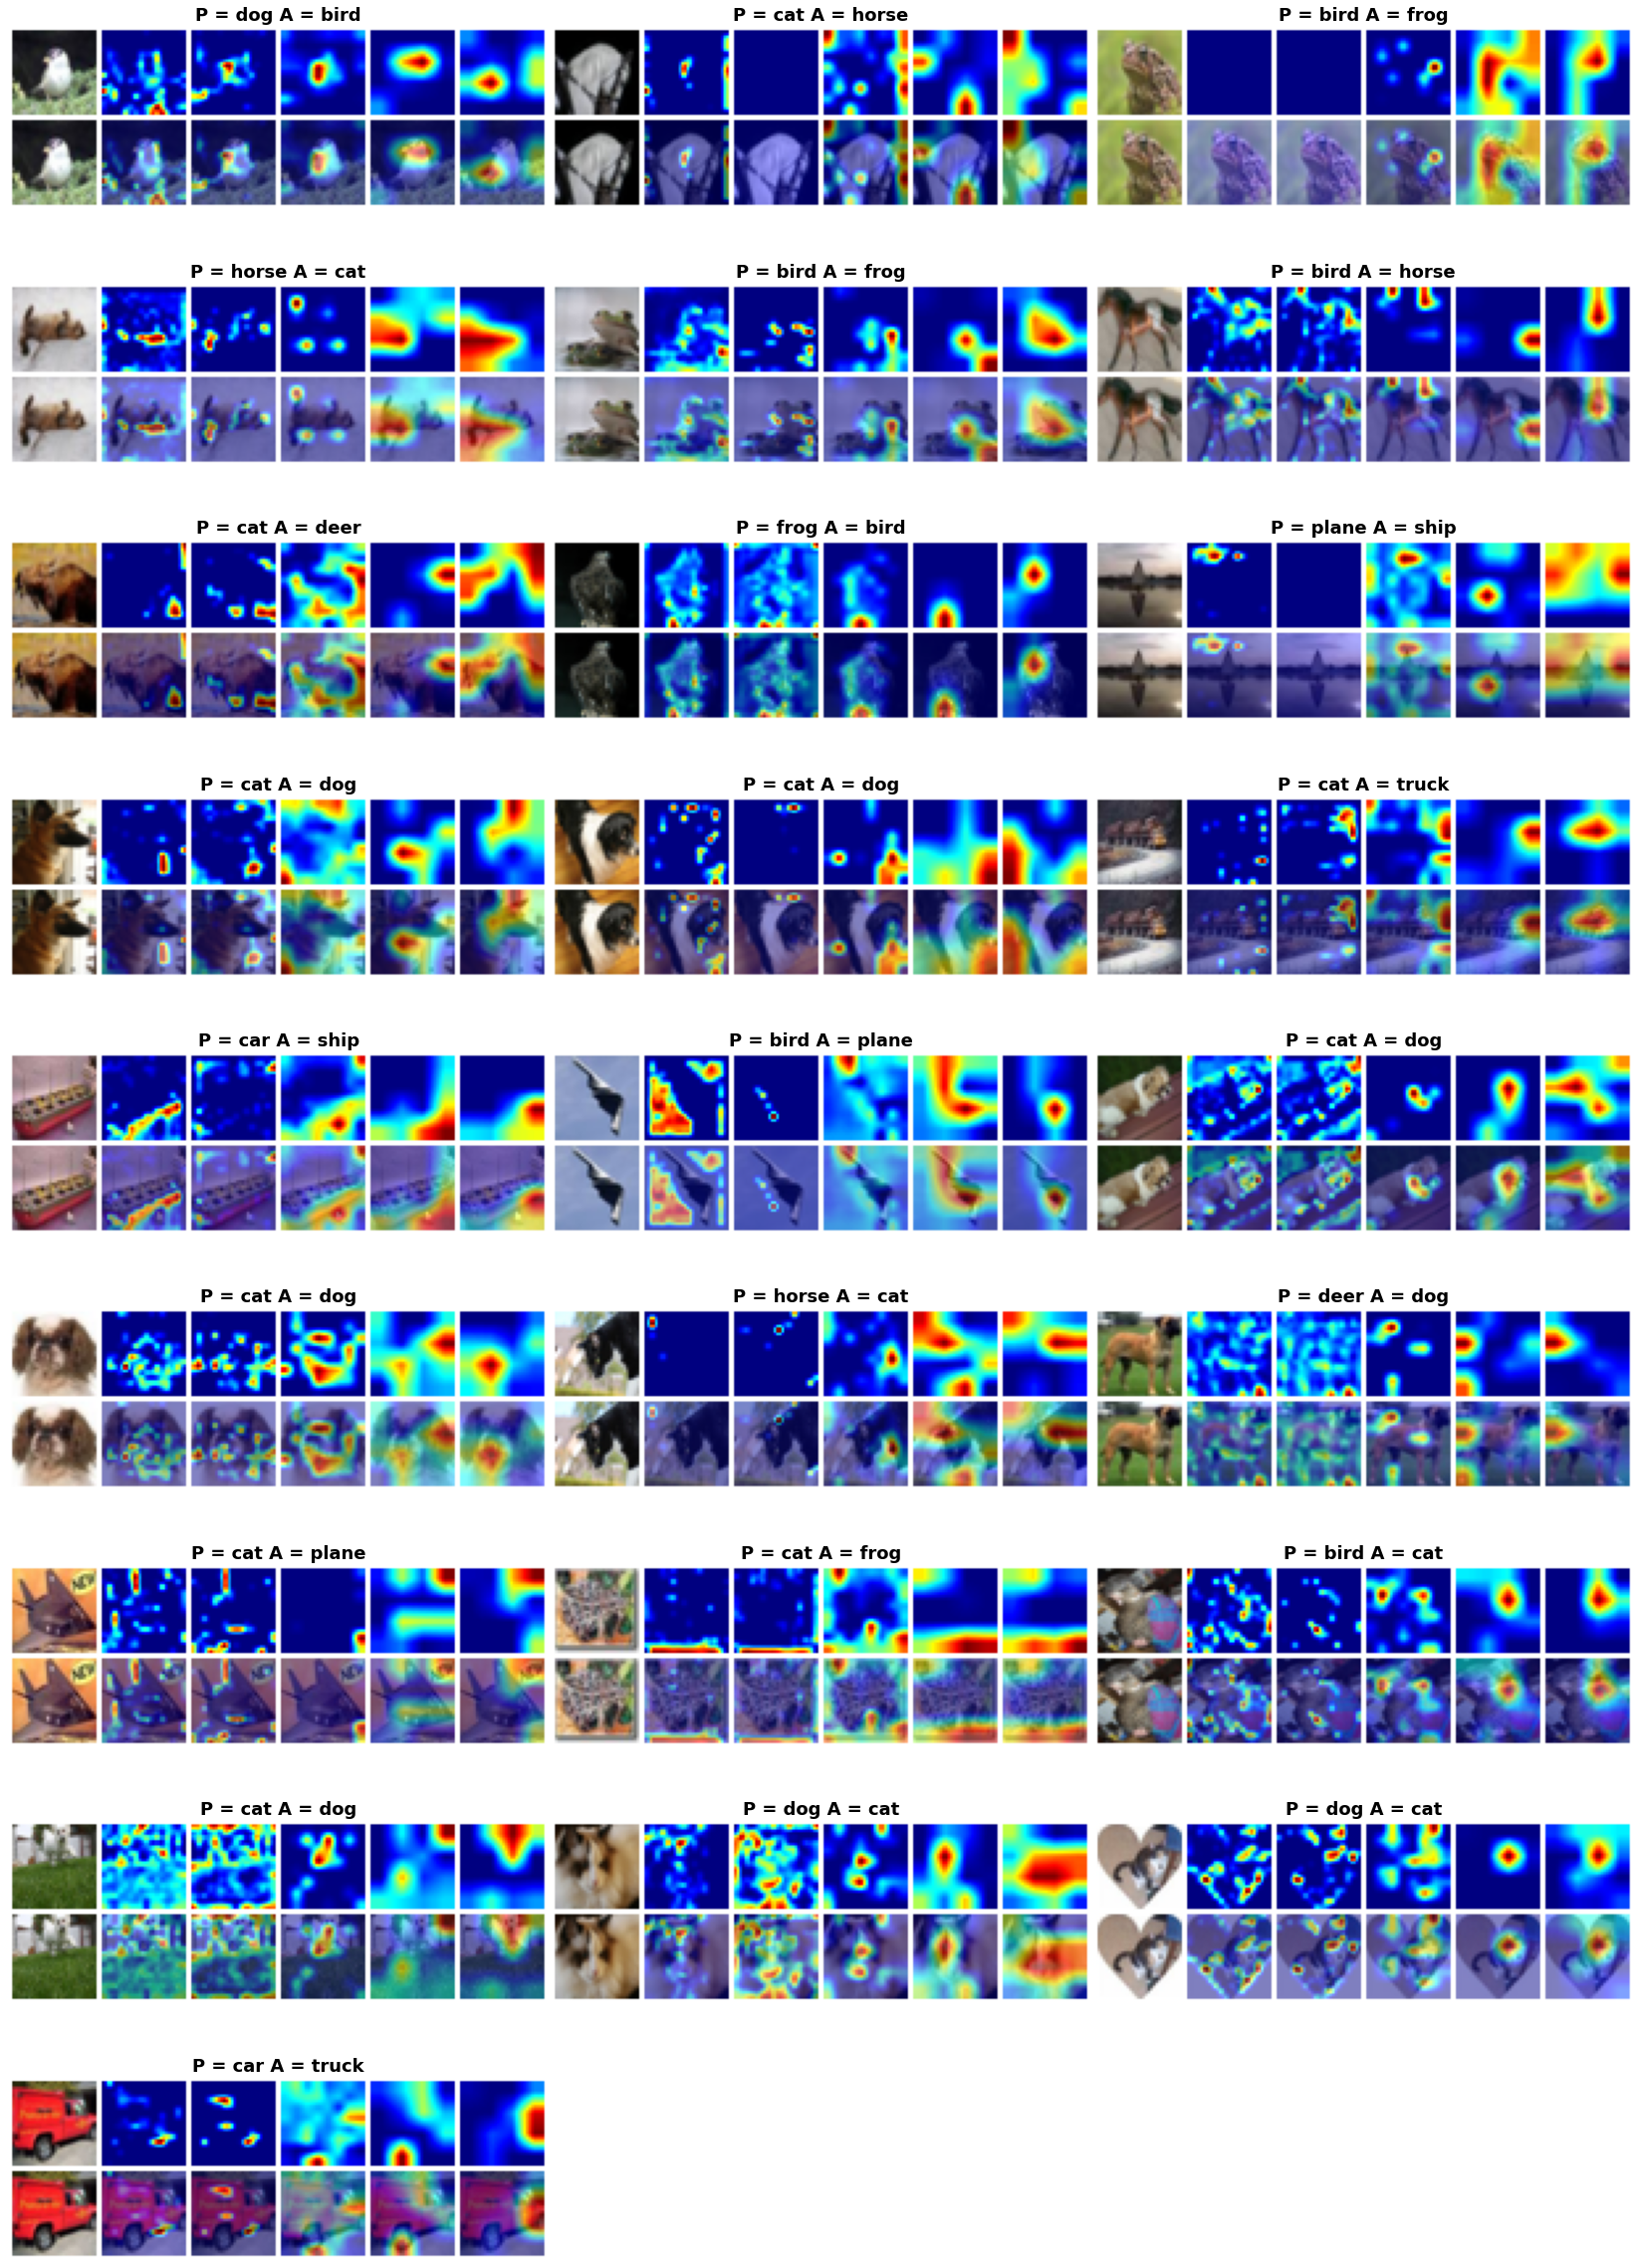

In [ ]:
layers = [model.layer1, model.resnet_layer1, model.layer2, model.layer3, model.resnet_layer3]
Plot.plot_gradcam_images(model, layers, miscassified_images, classes)

### **Visualize the CYCLIC triangle plot using learning rates which used for each epochs**

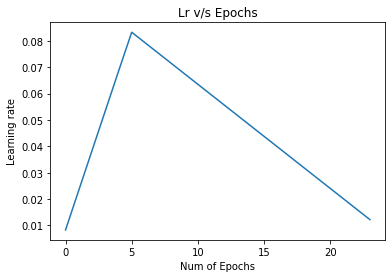

In [26]:
Plot.plot_cycle_lr(EPOCHS, lr_update)

### **Plot graphs**

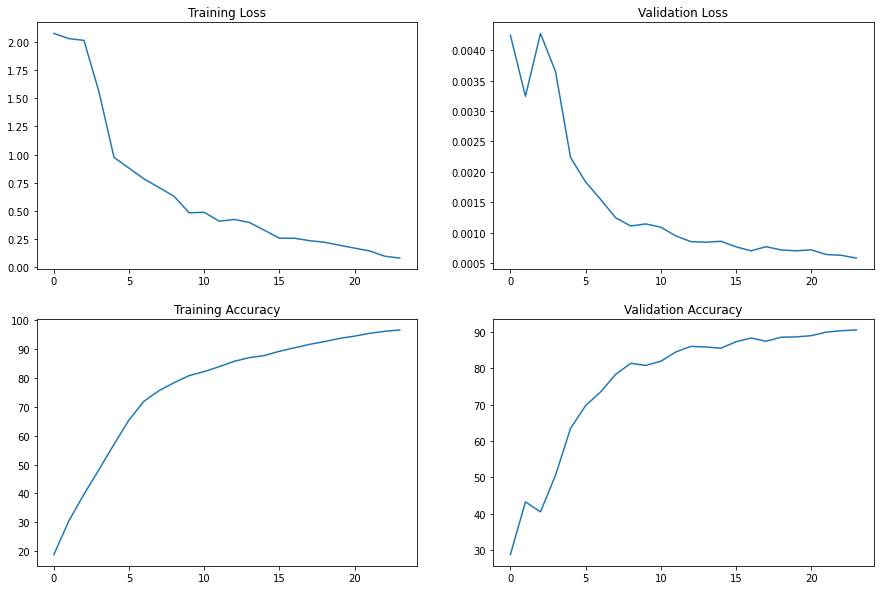

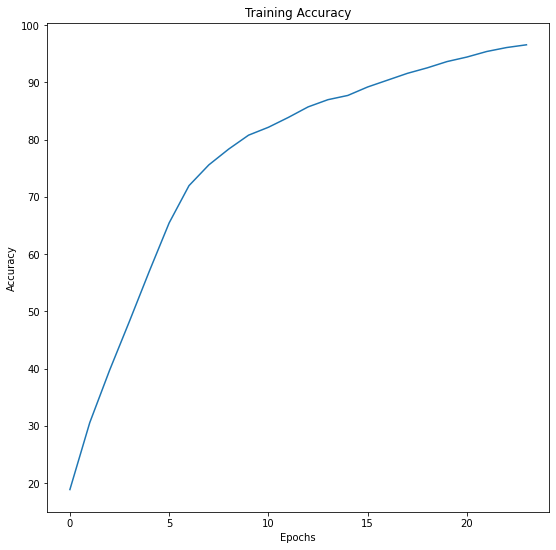

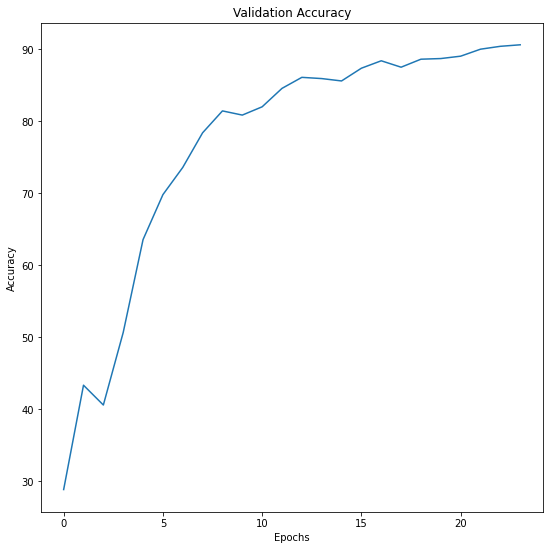

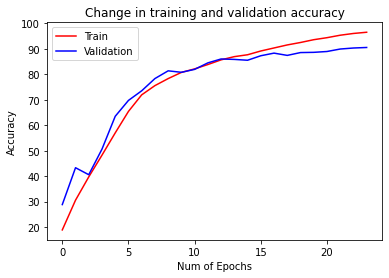

In [30]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
# Plot all graph
plt_obj.display_all_plot()
plt_obj.plot_train_graph()
plt_obj.plot_validation_graph()
plt_obj.plot_graph(plot_case="Accuracy")

### **Plot misclassified images**

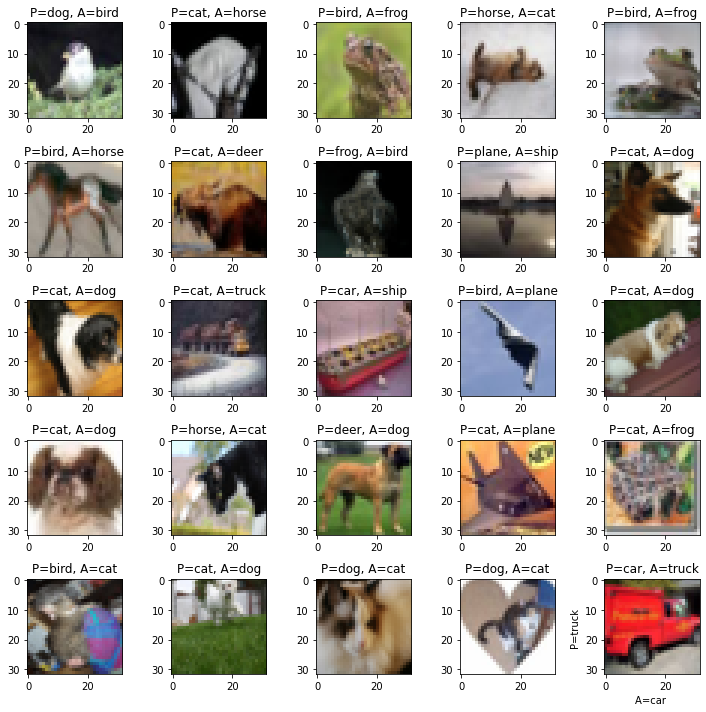

In [ ]:
Plot.plot_classified_images(classes, miscassified_images, image_name="gradcam_misclssified.png")